## Lab 3
### Part 1: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [18]:
! pip install torchsummary

In [19]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [20]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print("Directory", path, "is created!")
    else:
        print("Directory", path, "already exists!")


root_path = "fmnist"
mkdir(root_path)

Directory fmnist already exists!


In [21]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(
    root_path, train=True, transform=train_transform, target_transform=None, download=download
)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(
    root_path, train=False, transform=test_transform, target_transform=None, download=download
)

In [22]:
train_loader = torch.utils.data.DataLoader(
    fmnist_dataset_train, batch_size=128, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    fmnist_dataset_test, batch_size=256, shuffle=False, num_workers=2
)

In [23]:
len(fmnist_dataset_test)

10000

In [24]:
for img, label in train_loader:
    print(img.shape)
    #     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [25]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 28 * 5),
            nn.Dropout(p = 0.1),
            nn.ReLU(),
            
            nn.Linear(28 * 5, 28),
            nn.BatchNorm1d(28),
            nn.ReLU(),
            
            nn.Linear(28, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [26]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 140]         109,900
           Dropout-3                  [-1, 140]               0
              ReLU-4                  [-1, 140]               0
            Linear-5                   [-1, 28]           3,948
       BatchNorm1d-6                   [-1, 28]              56
              ReLU-7                   [-1, 28]               0
            Linear-8                   [-1, 10]             290
        LogSoftmax-9                   [-1, 10]               0
Total params: 114,194
Trainable params: 114,194
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.44
Estimated Total Size (MB): 0.45
-------------------------------------------

Your experiments come here:

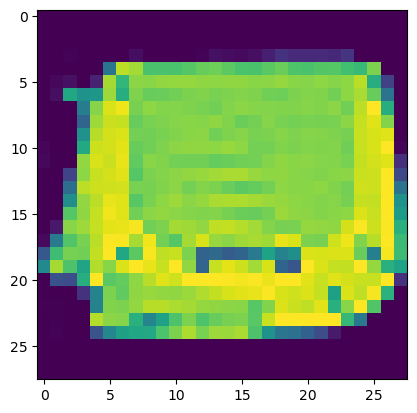

In [27]:
import matplotlib.pyplot as plt
inputs, classes = next(iter(train_loader))   
plt.imshow(inputs[0][0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
diff time:0:06:32.212839
0.8916015625


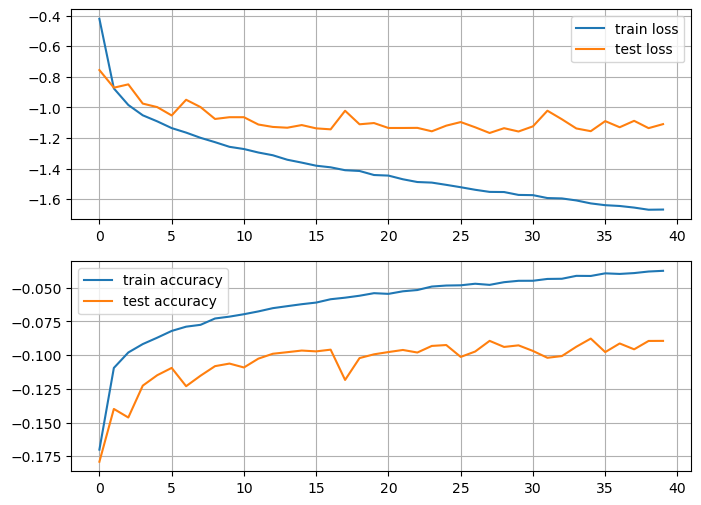

In [28]:
from sklearn.metrics import accuracy_score
import datetime

model = TinyNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_func = nn.NLLLoss()

#Your experiments, come here

def train(trI_loader, valid_loader, model, optimizer, loss_func, epochs = 10):
    trLH = []
    teLH = []
    trAH = []
    teAH = []
    
    trL = 0.0
    trA = 0.0
    vL = 0.0
    vA = 0.0

    start = datetime.datetime.now()
    for i in range(epochs):
        print(i)
        model.train()
        
        for trI, label in trI_loader:
            optimizer.zero_grad()
            loss = loss_func(model(trI.to(device)), label.to(device))
            loss.backward()
            optimizer.step()

            trL += loss.item() * trI.size(0)
            trA += accuracy_score(label, torch.argmax(model(trI.to(device)), dim = 1).cpu())

        model.eval()
        for trI, label in valid_loader:
            loss = loss_func(model(trI.to(device)), label.to(device))
            vL += loss.item() * trI.size(0)
            vA += accuracy_score(label, torch.argmax(model(trI.to(device)), dim = 1).cpu())

        trL = trL / len(train_loader.sampler)
        vL = vL / len(test_loader.sampler)
        trA = trA / len(train_loader)
        vA = vA / len(test_loader)
        
        trLH.append(trL)
        teLH.append(vL)
        trAH.append(trA)
        teAH.append(vA)
    finish = datetime.datetime.now()
    print(f'diff time:{str(finish - start)}')
    model.eval()
    AS = 0
    for t, label in test_loader:      
        AS += accuracy_score(label, torch.argmax(model(t.to(device)) , dim = 1).cpu())
    print(AS / len(test_loader))
    
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    
    ax[0].plot(np.log(trLH), label = 'train loss')
    ax[0].plot(np.log(teLH), label = 'test loss')
    ax[0].legend()
    ax[0].grid()

    
    ax[1].plot(np.log(trAH), label = 'train accuracy')
    ax[1].plot(np.log(teAH), label = 'test accuracy')
    ax[1].legend()
    ax[1].grid()

train(train_loader, test_loader, model, opt, loss_func, epochs = 40)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [29]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes = 10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape * num_classes),
            nn.ReLU(),
            
            nn.Linear(input_shape * num_classes, input_shape),
            nn.ReLU(),
            
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [30]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 7840]       6,154,400
              ReLU-3                 [-1, 7840]               0
            Linear-4                  [-1, 784]       6,147,344
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 12,309,594
Trainable params: 12,309,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 46.96
Estimated Total Size (MB): 47.10
----------------------------------------------------------------


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
diff time:0:06:46.894974
0.8990234375


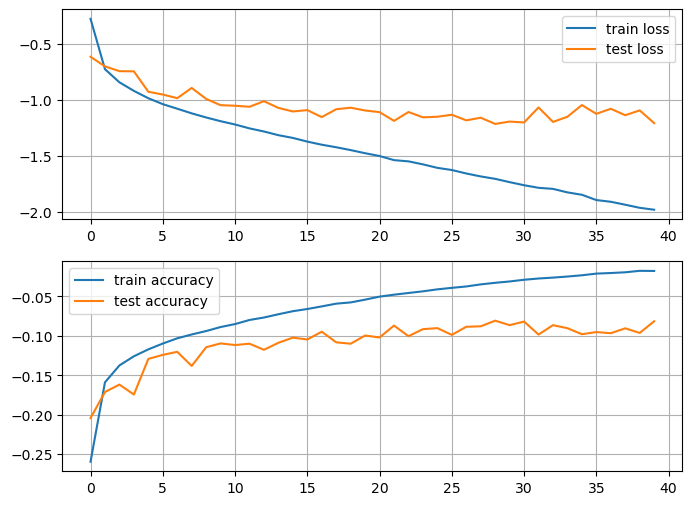

In [31]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_func = nn.NLLLoss()

train(train_loader, test_loader, model, opt, loss_func, epochs = 40)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [32]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28 * 28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),  # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes * input_shape),
            nn.Dropout(p = 0.99),
            nn.ReLU(),
            
            nn.Linear(num_classes * input_shape, input_shape),
            nn.Dropout(p = 0.9),
            nn.ReLU(),
            
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [33]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28 * 28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 7840]       6,154,400
           Dropout-3                 [-1, 7840]               0
              ReLU-4                 [-1, 7840]               0
            Linear-5                  [-1, 784]       6,147,344
           Dropout-6                  [-1, 784]               0
              ReLU-7                  [-1, 784]               0
            Linear-8                   [-1, 10]           7,850
        LogSoftmax-9                   [-1, 10]               0
Total params: 12,309,594
Trainable params: 12,309,594
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 46.96
Estimated Total Size (MB): 47.16
-----------------------------------

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
diff time:0:06:46.993364
0.89228515625


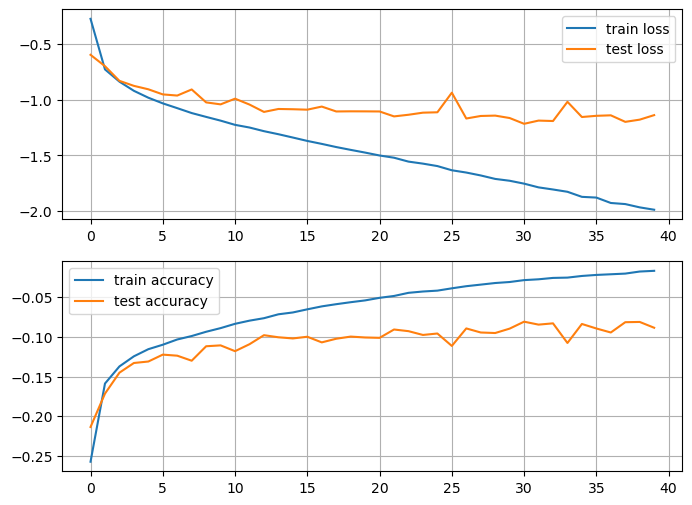

In [34]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr = 0.05)
loss_func = nn.NLLLoss()

# Your experiments, come here
train(train_loader, test_loader, model, opt, loss_func, epochs = 40)

### Conclusions:
_Write down small report with your conclusions and your ideas._

test accuracy почти не изменилась (немного стала меньше), скорость обучения осталась примерно такой же.